# Training the Continuum Model
In this notebook, the continuum model is trained against the CG model by global fitting free energies at the midplane and at the interface for the membrane translocation of single amino acids.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os, sys, json, shutil
from math import asinh, sqrt, pi
import pandas as pd
import glob
import mdtraj as md
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.linalg import svd
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/giulio/miniconda3/envs/pepmem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
plt.rcParams.update({'font.size': 12,'xtick.major.pad':3,'ytick.major.pad':3,'figure.dpi':80,
                     'xtick.major.size':6,'ytick.major.size':6,'legend.fontsize':12,
                     'xtick.direction':'out','ytick.direction':'out','axes.labelsize':12,
                     'axes.linewidth':1.2,'xtick.labelsize':12,'ytick.labelsize':12,
                     'xtick.major.width':1.2, 'ytick.major.width':1.2})

In [3]:
if os.path.isfile('coarsegrained/pmfs.p'):
    pmfs = pd.read_pickle('coarsegrained/pmfs.p')

### Free Energy to Form a Water-filled Cavity at the Midplane

6.2 +/- 0.3 kT/nm^2
0.06 +/- 0.01 nm


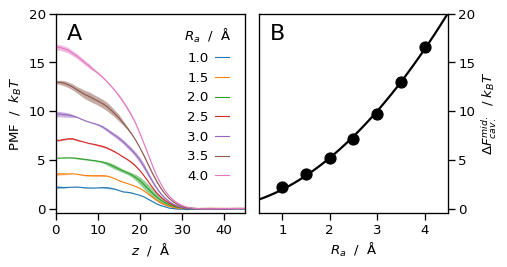

In [4]:
plt.rcParams.update({'figure.figsize': [6.5, 3.5]})
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)

radii = np.array(pmfs.index.get_level_values('R'))
radii = np.unique(radii)

cnt = 0
for R in radii:
    x = pmfs.loc[0,0,0,R]['x0']
    y = pmfs.loc[0,0,0,R]['y0']
    Ey = pmfs.loc[0,0,0,R]['Ey0']
    ax1.plot(x,y,lw=1,label='{:1.1f}'.format(R),color=colors[cnt])
    ax1.fill_between(x,y-Ey,y+Ey,alpha=.5,color=colors[cnt],lw=0)
    cnt += 1

func = lambda x,a,b : a*4*pi*(x+b)**2
mx = pmfs.loc[0,0,0]['max0'].values
emx = pmfs.loc[0,0,0]['Emax0'].values
popt,pcov = curve_fit(func,radii,mx,p0=[12,.1])
print(round(popt[0]*100,1),'+/-',round(np.sqrt(np.diag(pcov))[0]*100,1),'kT/nm^2')
print(round(popt[1]/10,2),'+/-',round(np.sqrt(np.diag(pcov))[1]/10,2),'nm')
x = np.linspace(0,4.5,100)
ax2.plot(x, func(x,*popt),lw=2,color='k')
ax2.errorbar(radii,mx,emx,lw=0,marker='o',color='k',
    markeredgecolor=None,ms=10,elinewidth=1.,capsize=2,capthick=1.)

ax1.set_xticks(np.arange(0,41,10))
ax2.set_xticks(np.arange(1,4.5,1))
ax1.set_xticklabels(['{:1g}'.format(i) for i in np.arange(0,41,10)])
ax2.set_xticklabels(['{:1g}'.format(i) for i in np.arange(1,4.5,1)])
ax1.set_xlabel('$z$  /  Å'); ax1.set_ylabel('PMF  /  $k_B T$')
ax2.set_xlabel('$R_a$  /  Å'); ax2.set_ylabel('$\Delta F_{cav.}^{mid.}$  / $k_B T$')
ax1.set_xlim(0,45); ax1.set_ylim(-.5,20)
ax2.set_xlim(0.5,4.5); ax2.set_ylim(-.5,20)
ax2.yaxis.set_label_position('right'); ax2.yaxis.set_ticks_position('right')
ax1.annotate(r'A',xy=(0.06,.87), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.87), fontsize=20, xycoords='axes fraction')
ax1.legend(handlelength=1,handletextpad=0.5,loc='upper right',fancybox=False,borderpad=.5,
               frameon=False,fontsize=12,markerfirst=False,title='$R_a$  /  Å')
f.tight_layout(w_pad=.1)    
f.savefig('figs/cavity.pdf')
plt.show()

### Expressions of Free Energy Values for Amino Acids at the Midplane and at the Interface

In [5]:
def min0(x,aa,ah,at,m1,m2,m3):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*aa*x**3*Rl**3/2.
    s=m1*ah
    I1= m3*3*(b+s)/b**4 - m3*3./(b+s)**3 + 3*h/(b+s)**4
    I2= 3*(b+s-h)/(b+s)**4 + 1./(b+s)**3 - 1./(t+h)**3
    I3= 1./(t+h)**3 - 1./(t+2*h)**3
    return C*(ah*I1+at*I2+ah*I3)+.5*2*pi*(x+s-h)*(x+s)
def max0(x,aa,ah,at,m1,m2,m3):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*aa*x**3*Rl**3/2.
    m1=0
    s=m1*(ah-at)+m2
    I1=4./b**3 - 8./t**3 
    I2=8./t**3 - 1./(t/2.+h)**3
    #I1=4./(b+s)**3 - 8./t**3 
    #I2=8./t**3 - 1./(t/2.+h)**3 + 3*(b+s)/b**4 - 3./(b+s)**3
    return C*(m3*at*I1+ah*I2)+6.2*4*np.pi*(x+s)**2
def min1(x,aa,ah,at,m1,m2,m3):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*Rl**3*.71/2.
    s=m1*ah
    I1= m3*(b+s)/b/b - m3*1./(b+s) + h/(b+s)**2
    I2= (b+s-h)/(b+s)**2 + 1./(b+s) - 1./(t+h)
    I3= 1./(t+h) - 1./(t+2*h)
    return C*(ah*I1+at*I2+ah*I3)+.5*2*np.pi*(x+s-h)*(x+s)
def max1(x,aa,ah,at,m1,m2,m3):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*Rl**3*.71
    s=m1*(ah-at)
    I1= 2./(b+s) - 2./t
    I2= 2./t - 1./(t/2.+h)  
    I3= (b+s)/b/b - 1./(b+s)
    return C*(at*I1+ah*I2+m3*ah*I3)+6.2*4*np.pi*(s+m2)**2

In [6]:
# copied from curve_fit 
def error_analysis(res):
    cost = 2 * res.cost  # res.cost is half sum of squares!
    s_sq = cost / (res.fun.size - res.x.size) # residual variance or reduced chi squared
    # Do Moore-Penrose inverse discarding zero singular values.
    _, s, VT = svd(res.jac, full_matrices=False)
    threshold = np.finfo(float).eps * max(res.jac.shape) * s[0]
    s = s[s > threshold]
    VT = VT[:s.size]
    pcov = np.dot(VT.T / s**2, VT) * s_sq # variance-covariance matrix
    return np.sqrt(np.diag(pcov)), s_sq # errors on the params are the diagonal elements of pcov

### Global Fits

In [7]:
df = {}

In [8]:
def fitting(extr,param0,lbound,ubound):
    radii = np.array([1.5,2,2.5,3])/10
    x = np.linspace(.14,.31,100)
    ahs = np.array([25,30,35]); ats = np.array([-30,-35])
    func = min0 if extr=='min0' else min1 if extr=='min1' else max0 if extr=='max0' else max1
    aas = np.array([1]) if extr[-1]=='1' else np.array([1,2])
    allx = []; ally = []; allyerr = []
    for aa in aas:
        for ah in ahs:
            for at in ats:
                mn = pmfs.loc[ah,at,aa][extr].values
                emn = pmfs.loc[ah,at,aa]['E'+extr].values
                allx.append(radii)
                ally.append(mn)
                allyerr.append(emn)
    args = allx, ally, allyerr, aas, ahs, ats
    def leastsq_function(p, *args):
        allx, ally, allyerr, aas, ahs, ats = args
        residuals = np.empty(0)
        cnt = 0
        for aa in aas:
            for ah in ahs:
                for at in ats:
                    param = aa, ah, at, p[0], p[1], p[2]
                    r = ( ally[cnt] - func(allx[cnt], *param) ) 
                    residuals = np.append(residuals, r)
                    cnt += 1
        return residuals
    res = least_squares(leastsq_function, x0=param0, args=args, bounds=[lbound,ubound])
    for aa in aas:
        mrkr = 'o' if aa==1 else '^'
        cnt = 0
        for ah in ahs:
            for at in ats:
                m = pmfs.loc[ah,at,aa][extr].values
                em = pmfs.loc[ah,at,aa]['E'+extr].values
                params = aa,ah,at,res.x[0],res.x[1],res.x[2]
                plt.plot(x,func(x,*params),color=colors[cnt])
                plt.errorbar(radii,m,em,lw=0,marker=mrkr,color=colors[cnt],
                    markeredgecolor=None,ms=10,elinewidth=1.,capsize=2,
                    capthick=1.,label=str(ah)+'_'+str(at)+'_'+str(aa))
                cnt += 1
                if cnt > 9: cnt = 0
    plt.xlabel('$R_a$  / nm')
    plt.ylabel('$\Delta F$  / $k_B T$')
    #plt.legend()
    plt.show()
    error = np.empty(0)
    for aa in aas:
        mrkr = 'o' if aa==1 else '^'
        cnt = 0
        for ah in ahs:
            for at in ats:
                m = pmfs.loc[ah,at,aa][extr].values
                em = pmfs.loc[ah,at,aa][extr].values
                params = aa,ah,at,res.x[0],res.x[1],res.x[2]
                plt.errorbar(radii,np.abs(m-func(radii,*params)),em/m*np.abs(m-func(radii,*params)),
                    lw=0,marker=mrkr,color=colors[cnt],markeredgecolor=None,ms=10,elinewidth=1.,
                    capsize=2,capthick=1.,label=str(ah)+'_'+str(at)+'_'+str(aa))
                error = np.append(error,np.power(m-func(radii,*params),2))
                cnt += 1
                if cnt > 9: cnt = 0
    plt.xlabel('$R_a$  / nm')
    plt.ylabel('| $\Delta \Delta F$ |  / $k_B T$')
    plt.legend()
    plt.show()
    table = pd.DataFrame({'Value':res.x,'Error':error_analysis(res)[0]},
             index=['m1','m2','m3'],columns=['Value','Error'])
    s = np.empty(0)
    for aa in aas:
        for ah in ahs:
            for at in ats:
                if extr=='max1':
                    s=np.append(s,res.x[0]*(ah-at))
                else:
                    s=np.append(s,res.x[0]*ah)
    return table, s, error

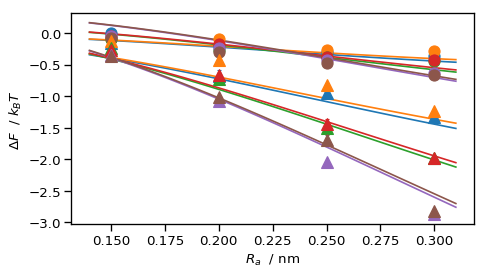

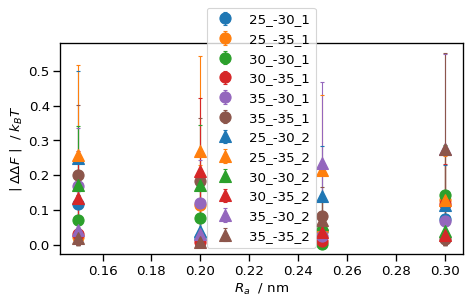

Thickness of the shell of HD beads: [0.43928394 0.43928394 0.52714072 0.52714072 0.61499751 0.61499751
 0.43928394 0.43928394 0.52714072 0.52714072 0.61499751 0.61499751]
Mean Thickness of the shell of HD beads: 0.5271407248781718 0.07173476658846502
Error: 0.2758798070538697 0.08390798692725324


,Value,Error
m1,0.017571,0.000453
m2,0.650102,0.000000
m3,1.153796,0.015314


In [9]:
param0 = [.1,1,1.1]  # initial parameters
lbound = [-1,0,1]    # lower bound
ubound = [2,6,6]     # upper bound
table,s,error = fitting('min0',param0,lbound,ubound)
print('Thickness of the shell of HD beads:',s)
print('Mean Thickness of the shell of HD beads:',s.mean(),s.std())
print('Error:',np.sqrt(error.max()),.5*error.std()/np.sqrt(error.mean()))
df['min0'] = table
table

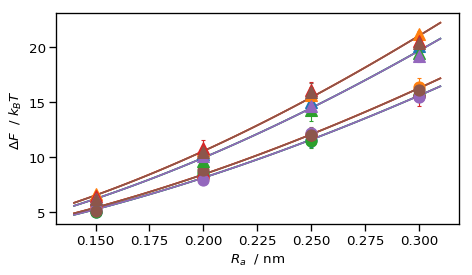

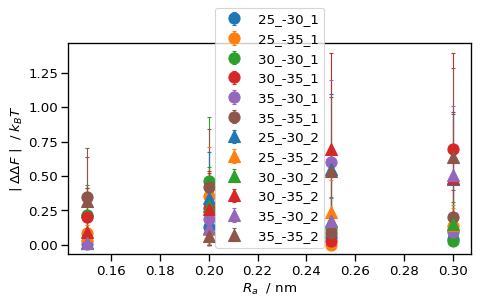

Thickness of the shell of HD beads: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean Thickness of the shell of HD beads: 0.0 0.0
Error: 0.6973643522977291 0.21260339441613285


,Value,Error
m1,0.000000,0.000000
m2,0.083811,0.002300
m3,3.356097,0.081171


In [10]:
param0 = [0,0,4]  # initial parameters
lbound = [-1,-1,0]        # lower bound
ubound = [2,2,50]          # upper bound
table,s,error = fitting('max0',param0,lbound,ubound)
print('Thickness of the shell of HD beads:',s)
print('Mean Thickness of the shell of HD beads:',s.mean(),s.std())
print('Error:',np.sqrt(error.max()),.5*error.std()/np.sqrt(error.mean()))
df['max0'] = table
table

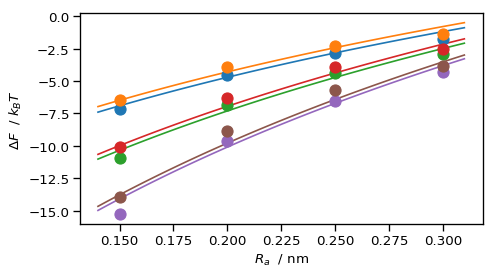

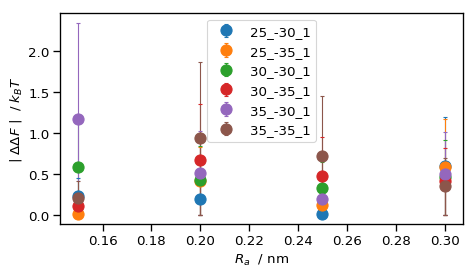

Thickness of the shell of HD beads: [1.43265161 1.43265161 1.71918194 1.71918194 2.00571226 2.00571226]
Mean Thickness of the shell of HD beads: 1.7191819350307436 0.23395102865755243
Error: 1.170857525060942 0.3030461434169201


,Value,Error
m1,0.057306,0.001909
m2,0.437381,0.000000
m3,0.926717,0.007425


In [11]:
param0 = [.1,0,3]  # initial parameters
lbound = [-1,0,0]    # lower bound
ubound = [1,1,10]     # upper bound
table,s,error = fitting('min1',param0,lbound,ubound)
print('Thickness of the shell of HD beads:',s)
print('Mean Thickness of the shell of HD beads:',s.mean(),s.std())
print('Error:',np.sqrt(error.max()),.5*error.std()/np.sqrt(error.mean()))
df['min1'] = table
table

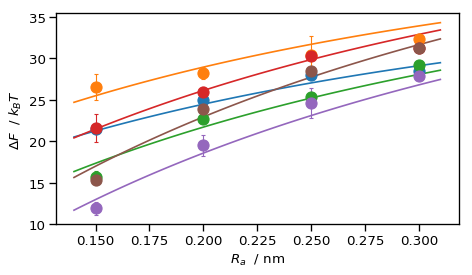

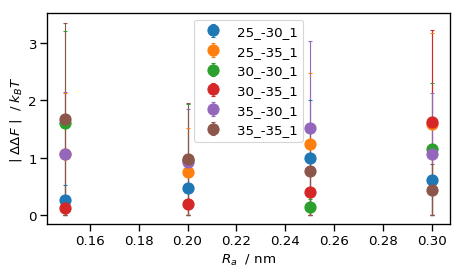

Thickness of the shell of HD beads: [0.51185818 0.55839074 0.55839074 0.6049233  0.6049233  0.65145586]
Mean Thickness of the shell of HD beads: 0.5816570175992016 0.04455153568529446
Error: 1.6797504823963205 0.43810629108252125


,Value,Error
m1,0.009307,0.000444
m2,0.221071,0.021370
m3,2.265694,0.083760


In [12]:
param0 = [.01,.1,2]  # initial parameters
lbound = [-1,0,0] # lower bound
ubound = [1,8,8] # upper bound
table,s,error = fitting('max1',param0,lbound,ubound)
print('Thickness of the shell of HD beads:',s)
print('Mean Thickness of the shell of HD beads:',s.mean(),s.std())
print('Error:',np.sqrt(error.max()),.5*error.std()/np.sqrt(error.mean()))
#print(table.loc['m1'].Value*(30+35)+table.loc['m2'].Value)
#print(table.loc['m1'].Value*(25)+table.loc['m3'].Value)
#print(table.loc['m1'].Value*(30)+table.loc['m3'].Value)
#print(table.loc['m1'].Value*(35)+table.loc['m3'].Value)
df['max1'] = table
table

In [13]:
print(pmfs.loc[30,-35,1,1.5]['max1'],pmfs.loc[30,-35,1,3]['max1'])

21.591862550000002 31.265203268999997


In [14]:
fitparams = pd.concat(df)
fitparams

Value     Error
max0 m1  0.000000  0.000000
     m2  0.083811  0.002300
     m3  3.356097  0.081171
max1 m1  0.009307  0.000444
     m2  0.221071  0.021370
     m3  2.265694  0.083760
min0 m1  0.017571  0.000453
     m2  0.650102  0.000000
     m3  1.153796  0.015314
min1 m1  0.057306  0.001909
     m2  0.437381  0.000000
     m3  0.926717  0.007425

In [15]:
def plotting(extr,sub,ahlg=0):
    radii = np.array([1.5,2,2.5,3])/10
    x = np.linspace(.14,.31,100)
    ahs = np.array([25,30,35]); ats = np.array([-30,-35])
    func = min0 if extr=='min0' else min1 if extr=='min1' else max0 if extr=='max0' else max1
    aas = np.array([1]) if extr[-1]=='1' else np.array([1,2])
    for aa in aas:
        mrkr = 'o' if aa==1 else '^'
        cnt = 0
        for ah in ahs:
            for at in ats:
                m = pmfs.loc[ah,at,aa][extr].values
                em = pmfs.loc[ah,at,aa]['E'+extr].values
                p = fitparams.loc[extr]['Value'].values
                params = aa,ah,at,p[0],p[1],p[2]
                sub.plot(x*10,func(x,*params),color=colors[cnt],lw=1)
                if ah==ahlg and mrkr=='o':
                    sub.errorbar(radii*10,m,em,lw=0,marker=mrkr,color=colors[cnt],
                        markeredgecolor=None,ms=7,elinewidth=1.,capsize=2,capthick=1.,
                        label=r'$\alpha_h$={:1g}'.format(ah)+r', $\alpha_t$={:1g}'.format(at))
                else:
                    sub.errorbar(radii*10,m,em,lw=0,marker=mrkr,color=colors[cnt],
                        markeredgecolor=None,ms=7,elinewidth=1.,capsize=2,capthick=1.)
                cnt += 1
                if cnt > 9: cnt = 0

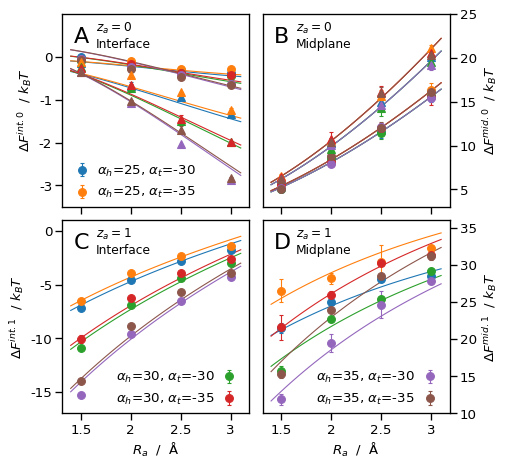

In [16]:
plt.rcParams.update({'figure.figsize': [6.5, 6]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
plotting('min0',ax1,25)
plotting('max0',ax2)
plotting('min1',ax3,30)
plotting('max1',ax4,35)
for ax in f.axes:
    ax.set_xticks(np.arange(1.5,3.5,.5))
ax3.set_xticklabels('{:1g}'.format(i) for i in np.arange(1.5,3.5,.5))
ax4.set_xticklabels('{:1g}'.format(i) for i in np.arange(1.5,3.5,.5))
ax1.set_xticklabels(np.tile([''],4))
ax2.set_xticklabels(np.tile([''],4))
ax1.set_ylim(-3.5,1); ax2.set_ylim(3,25)
ax3.set_ylim(-17,1); ax4.set_ylim(10,36)
ax1.set_yticks(np.arange(-3,.5,1)); ax2.set_yticks(np.arange(5,30,5))
ax3.set_yticks(np.arange(-15,1,5)); ax4.set_yticks(np.arange(10,40,5))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,.5,1))
ax2.set_yticklabels('{:1g}'.format(i) for i in np.arange(5,30,5))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(-15,1,5))
ax4.set_yticklabels('{:1g}'.format(i) for i in np.arange(10,40,5))
ax3.set_xlabel('$R_a$  /  Å'); ax4.set_xlabel('$R_a$  /  Å')
ax1.set_ylabel('$\Delta F^{int.0}$  / $k_B T$'); ax2.set_ylabel('$\Delta F^{mid.0}$  / $k_B T$')
ax3.set_ylabel('$\Delta F^{int.1}$  / $k_B T$'); ax4.set_ylabel('$\Delta F^{mid.1}$  / $k_B T$')
ax2.yaxis.set_ticks_position('right'); ax4.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right'); ax4.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate('$z_a=0$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax2.annotate('$z_a=0$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax3.annotate('$z_a=1$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax4.annotate('$z_a=1$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax1.legend(numpoints=1,handletextpad=0.1,loc='lower left',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=True)
ax3.legend(numpoints=1,handletextpad=0.1,loc='lower right',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=False)
ax4.legend(numpoints=1,handletextpad=0.1,loc='lower right',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=False)
f.tight_layout(w_pad=.1,h_pad=.1)    
f.savefig('figs/fit.pdf')
plt.show()